# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [4]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [5]:
DEVICE = 'cuda:0'
NDIM = 2 # number of parameters
NBINS = 1000
SIGMA = 0.01

In [22]:
SIGMA = 0.1
def model(z, w = 0.03):
    grid = np.linspace(0, 1, 32, 32)
    X, Y = np.meshgrid(grid, grid)
    x1, y1, r = z[0], z[1], z[2]*0.5
    R1 = ((X-x1)**2 + (Y-y1)**2)**0.5
    mu = np.exp(-(R1-r)**2/w**2/2)
    x = mu
    return x

def noisemodel(x, z = None):
    n = np.random.randn(*x.shape)*SIGMA  #*noiselevel
    return x + n

In [94]:
# Convolutional network as HEAD of inference network

class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, 3)
        self.conv2 = torch.nn.Conv2d(10, 20, 3)
        self.conv3 = torch.nn.Conv2d(20, 40, 3)
        self.pool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        nbatch = len(x)
        
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

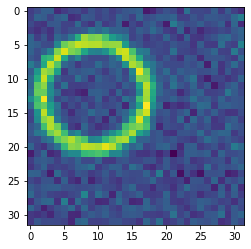

In [95]:
z0 = np.array([0.3, 0.4, .5])
x0 = noisemodel(model(z0))
plt.imshow(x0)

In [135]:
ds = swyft.DataStoreZarr("/home/ubuntu/volume1/ring3.zarr")
ds.init(zdim = 3, xdim = (32, 32))

Loading datastore: /home/ubuntu/volume1/ring3.zarr


In [136]:
sw_list = []

for i_round in range(6):
    parent = None if len(sw_list) == 0 else sw_list[-1]
    sw = swyft.SWYFT(x0, zdim = 3, device = DEVICE, head = Head, datastore = ds, nsamples = 2000, noisemodel = noisemodel, parent = parent)
    sw_list.append(sw)
    
    if sw.requires_sim():
        for i in ds.require_sim():
            z = ds.z[i]
            x = model(z)
            ds.add_sim(i, x)
            
    sw.train1d(max_epochs = 100, nbatch = 16)

Constrained posterior area: 1.0
Adding 1069 new samples. Run simulator!
Number of output features: 160
Start training
LR iteration 0
Total epochs: 14
Validation losses: [6.599543988704681, 5.902556374669075, 5.758092761039734, 5.385423883795738, 5.30008564889431, 4.904616340994835, 4.9228075966238976, 4.621300958096981, 4.577250227332115, 4.211838781833649, 4.162072904407978, 4.432305388152599, 4.962054014205933, 4.436525613069534]
LR iteration 1
Total epochs: 7
Validation losses: [3.868822656571865, 3.8868961930274963, 3.8819635286927223, 3.7915048971772194, 3.960456222295761, 3.8812458589673042, 3.919616773724556]
LR iteration 2
Total epochs: 5
Validation losses: [3.8541460931301117, 3.712156668305397, 3.741412065923214, 3.745158091187477, 3.768900528550148]
Constrained posterior area: 0.11190062
Adding 1718 new samples. Run simulator!
Number of output features: 160
Start training
LR iteration 0
Total epochs: 8
Validation losses: [6.106178641319275, 4.851508408784866, 4.3606316819787

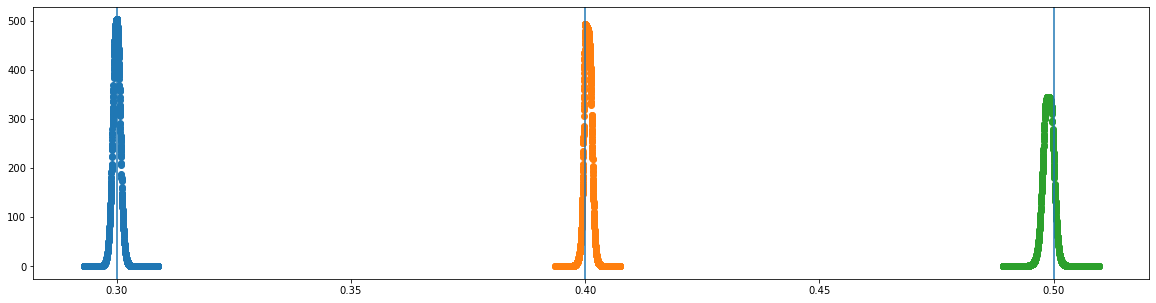

In [137]:
plt.figure(figsize=(20, 5))
for i in range(3):
    z, p = sw_list[-1].posterior(i)
    plt.axvline(z0[i])
    plt.scatter(z, p)